First score = 0.8277

In [1]:
%matplotlib inline

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import sklearn


from sklearn.preprocessing import normalize
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from public_auc_veolia2 import score_function

from utils import load_data, basic_preprocessing

In [2]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Activation
from keras.regularizers import l1,l2

Using TensorFlow backend.


In [3]:
input_train, output_train, input_submission = load_data()

In [4]:
df = basic_preprocessing(input_train)
df_out = (output_train['2014'] + output_train['2015'])>0

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, df_out, test_size=0.33, random_state= 1)

In [6]:
idx = y_train[y_train==True].index
idx_test = y_test[y_test==True].index

X_train_duplicated = X_train
y_train_duplicated = y_train

X_test_duplicated = X_test
y_test_duplicated = y_test


In [7]:
for k in range(8):
    X_train_duplicated = pd.concat([X_train_duplicated, X_train_duplicated.loc[idx]])
    y_train_duplicated = pd.concat([y_train_duplicated, y_train_duplicated.loc[idx]])
    X_test_duplicated = pd.concat([X_test_duplicated, X_test_duplicated.loc[idx_test]])
    y_test_duplicated = pd.concat([y_test_duplicated, y_test_duplicated.loc[idx_test]])

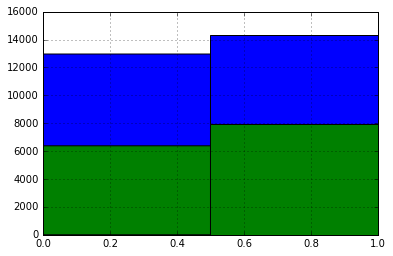

In [8]:
y_train_duplicated.hist(bins = 2)
y_test_duplicated.hist(bins = 2)

In [104]:
wreg = 0.001
model = Sequential()
model.add(Dense(20, activation='sigmoid', input_shape=(13,), W_regularizer=l2(wreg)))
model.add(Dense(100, activation='sigmoid', W_regularizer=l2(wreg)))
model.add(Dense(50, activation='sigmoid', W_regularizer=l2(wreg)))
model.add(Dense(20, activation='sigmoid', W_regularizer=l2(wreg)))
model.add(Dense(1, activation='sigmoid', W_regularizer=l2(wreg)))
model.compile(optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy'])

In [105]:
history = model.fit(np.array(X_train_duplicated), np.array(y_train_duplicated), validation_data=(np.array(X_test_duplicated), np.array(y_test_duplicated)),nb_epoch=10)

Train on 27296 samples, validate on 14316 samples
Epoch 1/10
27296/27296 [==============================] - 17s - loss: 0.6550 - acc: 0.6838 - val_loss: 0.4960 - val_acc: 0.7802
Epoch 2/10
27296/27296 [==============================] - 17s - loss: 0.5487 - acc: 0.7624 - val_loss: 0.5384 - val_acc: 0.7137
Epoch 3/10
27296/27296 [==============================] - 17s - loss: 0.5330 - acc: 0.7637 - val_loss: 0.5086 - val_acc: 0.7299
Epoch 4/10
27296/27296 [==============================] - 17s - loss: 0.5252 - acc: 0.7695 - val_loss: 0.4710 - val_acc: 0.8061
Epoch 5/10
27296/27296 [==============================] - 17s - loss: 0.5250 - acc: 0.7629 - val_loss: 0.4861 - val_acc: 0.7144
Epoch 6/10
27296/27296 [==============================] - 17s - loss: 0.5221 - acc: 0.7631 - val_loss: 0.5165 - val_acc: 0.7023
Epoch 7/10
27296/27296 [==============================] - 17s - loss: 0.5193 - acc: 0.7658 - val_loss: 0.4922 - val_acc: 0.7213
Epoch 8/10
27296/27296 [==============================

In [106]:
y = model.predict_on_batch(X_test_duplicated)

In [107]:
y_test_duplicated.shape

(14316,)

(array([ 2972.,   175.,   149.,   235.,  3161.,   624.,   627.,  4247.,
            0.,  2126.]),
 array([ 0.05521345,  0.14357249,  0.23193152,  0.32029055,  0.40864959,
         0.49700862,  0.58536766,  0.67372669,  0.76208572,  0.85044476,
         0.93880379]),
 <a list of 10 Patch objects>)

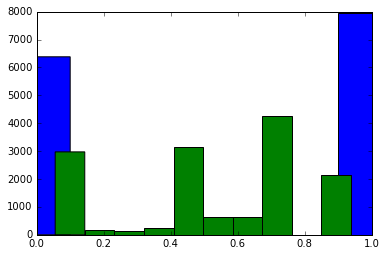

In [108]:
plt.hist(y_test_duplicated, bins=10)
plt.hist(y, bins=10)

In [42]:
from public_auc_veolia2 import score_function

In [78]:
y_pred = model.predict_on_batch(X_test)

In [51]:
y_tes = np.array([float(w) for w in y_test])

In [56]:
pred = np.array([y_pred, y_pred]).T[0]
true = np.array([y_tes,y_tes]).T

In [64]:
score_function(true, pred)

0.87088937202952765

In [81]:
X_submission = basic_preprocessing(input_submission)

In [82]:
y_pred = model.predict_on_batch(X_submission)

In [83]:
# Predictions for the submission data
sub_1 = y_pred
sub_2 = y_pred

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e23a940>]], dtype=object)

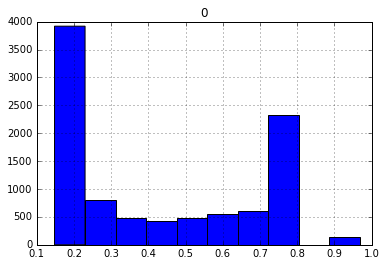

In [86]:
pd.DataFrame(y_pred).hist(bins=10)

In [85]:
# Submission formating
submission = pd.DataFrame()
submission['Id'] = input_submission.index.tolist()
submission['2014'] = sub_1[:]
submission['2015'] = sub_2[:]
submission = submission.set_index('Id')
submission.to_csv('../submissions/nn_20_100_20_1.csv',index=True,sep=';')